In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


In [2]:
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#1.tokenizer

In [2]:
import sentencepiece as spm

corpus_file = '/content/drive/MyDrive/kowiki.txt'
prefix = '/content/drive/MyDrive/ko_32000'
vocab_size = 32000
spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

In [3]:
vocab = spm.SentencePieceProcessor()
vocab.load("/content/drive/MyDrive/ko_32000.model")

True

In [77]:
print(vocab.piece_to_id("[PAD]"))

0


In [4]:
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            token = vocab.id_to_piece(id)
            vocab_list.append(token)

count=0
for token in vocab_list:
    print(token)
    count+=1
    if count>10:
        break

▁1
▁이
으로
에서
▁있
▁2
▁그
▁대
▁사
이다
었다


#2.MLM

In [5]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값, _
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

#3.SOP

In [6]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [7]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            #print("current_chunk:", len(current_chunk), current_length, current_chunk)

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            # print("is_next:", is_next)
            # print("tokens_a:", len(tokens_a), tokens_a)
            # print("tokens_b:", len(tokens_b), tokens_b)
            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # print("tokens:", len(tokens), tokens)
            # print("segment:", len(segment), segment)

            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)
            # print("masked tokens:", len(tokens), tokens)
            # print("masked index:", len(mask_idx), mask_idx)
            # print("masked label:", len(mask_label), mask_label)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)
            #######################################
            # print()

            current_chunk = []
            current_length = 0
    return instances

In [8]:
def create_pretrain_instances2(vocab, doc, n_seq):
    """
    doc별 pretrain 데이터 생성
    """
    # for [CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):  # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i])  # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
            #print("current_chunk:", len(current_chunk), current_length, current_chunk)

            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0    # False
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1   # True
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            # print("is_next:", is_next)
            # print("tokens_a:", len(tokens_a), tokens_a)
            # print("tokens_b:", len(tokens_b), tokens_b)
            #######################################

            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # print("tokens:", len(tokens), tokens)
            # print("segment:", len(segment), segment)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
            }
            instances.append(instance)
            #######################################
            # print()

            current_chunk = []
            current_length = 0
    return instances

#4.dataset

In [13]:
corpus_file = '/content/drive/MyDrive/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [13]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다.
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    save_pretrain_instances(out_f, doc)
                    doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)

In [9]:
def make_pretrain_data2(vocab, in_file, out_file, n_seq):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances2(vocab, doc, n_seq)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    save_pretrain_instances(out_f, doc)
                    doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)

In [10]:
pretrain_json_path = '/content/drive/MyDrive/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [14]:
pretrain_json_path = '/content/drive/MyDrive/bert_pre_train2.json'

make_pretrain_data2(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [11]:
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

862259

In [18]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [8]:
def load_pre_train_data(vocab, filename, n_seq, count=None, offset=0):
    """
    학습에 필요한 데이터를 로드 (train/valid 분할 가능)
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이
    :param count: 데이터 수 제한 (None이면 끝까지)
    :param offset: 데이터를 건너뛸 수 (valid set 로딩 시 사용)
    """
    total = 0
    # 전체 줄 수 미리 계산
    with open(filename, "r") as f:
        for _ in f:
            total += 1

    # 범위 제한
    if count is None:
        count = total - offset
    count = min(count, total - offset)

    # memmap 파일 정의
    enc_tokens = np.memmap(filename=f'enc_tokens.memmap_{offset}', mode='w+', dtype=np.int32, shape=(count, n_seq))
    segments = np.memmap(filename=f'segments.memmap_{offset}', mode='w+', dtype=np.int32, shape=(count, n_seq))
    labels_nsp = np.memmap(filename=f'labels_nsp.memmap_{offset}', mode='w+', dtype=np.int32, shape=(count,))
    labels_mlm = np.memmap(filename=f'labels_mlm.memmap_{offset}', mode='w+', dtype=np.int32, shape=(count, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if i < offset:
                continue
            if i >= offset + count:
                break

            data = json.loads(line)
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            label_nsp = data["is_next"]
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, 0, dtype=np.int32)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            j = i - offset
            enc_tokens[j] = enc_token
            segments[j] = segment
            labels_nsp[j] = label_nsp
            labels_mlm[j] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [10]:
def load_pre_train_data2(vocab, filename, n_seq, count=None, offset=0):
    """
    학습에 필요한 데이터를 로드 (train/valid 분할 가능)
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이
    :param count: 데이터 수 제한 (None이면 끝까지)
    :param offset: 데이터를 건너뛸 수 (valid set 로딩 시 사용)
    """
    total = 0
    # 전체 줄 수 미리 계산
    with open(filename, "r") as f:
        for _ in f:
            total += 1

    # 범위 제한
    if count is None:
        count = total - offset
    count = min(count, total - offset)

    # memmap 파일 정의
    enc_tokens = np.memmap(filename=f'enc_tokens.memmap_{offset}', mode='w+', dtype=np.int32, shape=(count, n_seq))
    segments = np.memmap(filename=f'segments.memmap_{offset}', mode='w+', dtype=np.int32, shape=(count, n_seq))
    labels_nsp = np.memmap(filename=f'labels_nsp.memmap_{offset}', mode='w+', dtype=np.int32, shape=(count,))
    #labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(count, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if i < offset:
                continue
            if i >= offset + count:
                break

            data = json.loads(line)
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            label_nsp = data["is_next"]
            # mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            # mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            # label_mlm = np.full(n_seq, 0, dtype=np.int32)
            # label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment)  == n_seq

            j = i - offset
            enc_tokens[j] = enc_token
            segments[j] = segment
            labels_nsp[j] = label_nsp
            #labels_mlm[j] = label_mlm

    return (enc_tokens, segments), (labels_nsp,)

In [11]:
pretrain_json_path = '/content/drive/MyDrive/bert_pre_train2.json'

In [10]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/862259 [00:00<?, ?it/s]

In [11]:
pre_valid_inputs, pre_valid_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=32000, offset=128000)

  0%|          | 0/862259 [00:00<?, ?it/s]

In [15]:
pre_train_inputs, pre_train_labels = load_pre_train_data2(vocab, pretrain_json_path, 128, count=128000)
pre_valid_inputs, pre_valid_labels = load_pre_train_data2(vocab, pretrain_json_path, 128, count=32000, offset=128000)

  0%|          | 0/862259 [00:00<?, ?it/s]

  0%|          | 0/862259 [00:00<?, ?it/s]

In [53]:
enc_tokens_np=pre_train_inputs[0]
print(enc_tokens_np.shape)
print(enc_tokens_np.dtype)
print("max:", np.max(enc_tokens_np), "min:", np.min(enc_tokens_np))
assert np.all((0 <= enc_tokens_np) & (enc_tokens_np < len(vocab)))

(128000, 128)
int32
max: 32006 min: 0


In [91]:
vocab.piece_to_id('[SEP]')

4

In [16]:
def map_fn(enc_tokens, segments, label_nsp):
    def py_masking_fn(enc_tokens_np):
      if isinstance(enc_tokens, tf.Tensor):
        enc_tokens_np = enc_tokens_np.numpy()

      #tokens = [vocab.id_to_piece(int(i)) for i in enc_tokens_np]
      tokens = []
      for idx, i in enumerate(enc_tokens_np.tolist()):
        try:
          piece = vocab.id_to_piece(int(i))
          tokens.append(piece)
        except Exception as e:
          print(f"[ERROR] vocab.id_to_piece failed at index {idx}, value={i}")
          raise e

      valid_tokens = [t for t in tokens if t != ["[PAD]"]]
      mask_cnt = int((len(valid_tokens) - 3) * 0.15)
      n_seq = len(enc_tokens_np)

      masked_tokens, mask_idx, mask_labels = create_pretrain_mask2(tokens, mask_cnt, vocab_list)
      masked_input_ids = [vocab.piece_to_id(t) for t in masked_tokens]

      # label_mlm 갱신
      mask_idx = np.array(mask_idx, dtype=np.int32)
      mask_label = np.array([vocab.piece_to_id(p) for p in mask_labels], dtype=np.int32)
      label_mlm = np.full(n_seq, 0, dtype=np.int32)
      label_mlm[mask_idx] = mask_label

      return np.array(masked_input_ids, dtype=np.int32), label_mlm

    masked_input_ids, updated_label_mlm = tf.py_function(
        func=py_masking_fn,
        inp=[enc_tokens],
        Tout=(tf.int32, tf.int32),
    )
    n_seq = enc_tokens.shape[0]
    masked_input_ids.set_shape([n_seq])
    updated_label_mlm.set_shape([n_seq])
    segments.set_shape([n_seq])

    return (masked_input_ids, segments), (label_nsp, updated_label_mlm)

In [17]:
def create_pretrain_mask2(tokens, mask_cnt, ids_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]" or token=="[PAD]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값, _
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0과 1 사이의 확률 값

        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 256

# pre_train_inputs: (enc_tokens, segments), pre_train_labels: (label_nsp)
train_dataset = tf.data.Dataset.from_tensor_slices((pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0]))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(map_fn, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((pre_valid_inputs[0], pre_valid_inputs[1], pre_valid_labels[0]))
valid_dataset = valid_dataset.map(map_fn, num_parallel_calls=AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.prefetch(AUTOTUNE)

In [24]:
for batch in train_dataset.take(1):
    (masked_input_ids, segments), (label_nsp, label_mlm) = batch
    print("masked_input_ids shape:", masked_input_ids.shape)
    print("segments shape:", segments.shape)
    print("label_nsp shape:", label_nsp.shape)
    print("label_mlm shape:", label_mlm.shape)
    print("masked_input_ids[0]:", masked_input_ids[0])
    break

masked_input_ids shape: (64, 128)
segments shape: (64, 128)
label_nsp shape: (64,)
label_mlm shape: (64, 128)
masked_input_ids[0]: tf.Tensor(
[    5  1029  9508   151  2090  3065  9821  8933 21626     6     6     6
    47 27600 28232 27613 15536  4010 27630  2398   354 14569    48 27611
   799 13287     6     6 25804 27609  1002  7412 27661   169   189 27630
 28043   585  8693 27596 30644 27630  2090  3065   348     6     6     6
  8756 27600  3992    54  2090  3065 27626   396  2721 23417  3389 25208
  6784 28051    43 27599     4  3165  1274     6  3034 27612  2090  3065
   423  5304   765  1122 27644  8438   665  2298    40  2788  7446 21636
     6     6  6193  2722  1002 16344 24234  7256 10108 22015    70  8578
  3333   167 28014    42  1060     6     6     6     6     6   160  3152
 27625  3415 28681 27751     6     6  2090  3065   348 13170 27597  1353
   127  7926 27760    12 20940  6186    10     4], shape=(128,), dtype=int32)


In [25]:
vocab.id_to_piece(6)

'[MASK]'

#5.model 코드, prenorm, cylcle-lr 추가 및 수정
LLRD 를 위한 이름붙이기(실패)


In [19]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model

    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                name="weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer(),name=f"{name}_Qmatrix")
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, self.n_head * self.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config, name=f"{name}_MHA")
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon, name=f"{name}_norm1")

        self.ffn = PositionWiseFeedForward(config, name=f"{name}_ffn")
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon, name=f"{name}_norm2")

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_embed, self_mask):
      """
      Pre-Norm 방식의 Encoder Layer
      :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
      :param self_mask: enc_tokens의 pad mask
      :return enc_out: EncoderLayer 실행 결과
      """
      # Self-Attention with Pre-Norm
      norm1_val = self.norm1(enc_embed)
      self_attn_val = self.self_attention(norm1_val, norm1_val, norm1_val, self_mask)
      attn_out = enc_embed + self.dropout(self_attn_val)

      # Feed-Forward with Pre-Norm
      norm2_val = self.norm2(attn_out)
      ffn_val = self.ffn(norm2_val)
      enc_out = attn_out + self.dropout(ffn_val)

      return enc_out

class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        # self.encoder_layers = []
        # for i in range(config.n_layer):
        #     layer = EncoderLayer(config, name=f"encoder_layer_{i}")
        #     setattr(self, f"encoder_layer_{i}", layer)
        #     self.encoder_layers.append(layer)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        #enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)
        enc_self_mask = tf.keras.layers.Lambda(lambda x: get_pad_mask(x, self.i_pad), name='enc_self_mask')(enc_tokens)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [20]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), dtype=y_true.dtype)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

In [28]:
class CosineRestartSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, cycle_steps, max_lr=2.5e-4, min_lr=1e-6, cycle_mult=1.5):
        """
        :param max_lr: 최대 learning rate
        :param min_lr: 최소 learning rate
        :param warmup_steps: 워밍업 스텝 수
        :param cycle_steps: 첫 번째 주기의 step 수
        :param cycle_mult: 주기 확장 계수
        """
        super().__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.init_cycle_steps = cycle_steps
        self.cycle_mult = cycle_mult

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warmup phase
        if_warmup = tf.less_equal(step, self.warmup_steps)
        warmup_lr = (step / self.warmup_steps) * self.max_lr

        # Cosine Annealing with Restarts phase
        step_after_warmup = tf.maximum(0., step - self.warmup_steps)

        # Determine which cycle we're in
        cycle = 0
        cycle_len = self.init_cycle_steps
        total = 0.
        while True:
            if step_after_warmup < total + cycle_len:
                break
            total += cycle_len
            cycle += 1
            cycle_len *= self.cycle_mult

        # local step in current cycle
        cycle_progress = (step_after_warmup - total) / cycle_len
        cosine_decay = 0.5 * (1. + tf.math.cos(math.pi * cycle_progress))
        annealing_lr = self.min_lr + (self.max_lr - self.min_lr) * cosine_decay

        return tf.where(if_warmup, warmup_lr, annealing_lr)

In [21]:
class CosineRestartSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, cycle_steps, max_lr=2.5e-4, min_lr=1e-6, cycle_mult=1.5):
        super().__init__()
        self.max_lr = tf.constant(max_lr, dtype=tf.float32)
        self.min_lr = tf.constant(min_lr, dtype=tf.float32)
        self.warmup_steps = tf.constant(warmup_steps, dtype=tf.float32)
        self.init_cycle_steps = tf.constant(cycle_steps, dtype=tf.float32)
        self.cycle_mult = tf.constant(cycle_mult, dtype=tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        warmup_lr = (step / self.warmup_steps) * self.max_lr

        step_after = tf.maximum(0., step - self.warmup_steps)

        # 현재 cycle index 계산 (수식 기반)
        log_base = tf.math.log(self.cycle_mult)
        inner = 1. + (self.cycle_mult - 1.) * step_after / self.init_cycle_steps
        cycle_idx = tf.floor(tf.math.log(inner) / log_base)

        # 해당 cycle의 시작 step (누적 step)
        pow_k = tf.pow(self.cycle_mult, cycle_idx)
        total_prev = self.init_cycle_steps * (pow_k - 1.) / (self.cycle_mult - 1.)
        cycle_len = self.init_cycle_steps * pow_k

        # 현재 cycle 내 진행률
        cycle_progress = (step_after - total_prev) / cycle_len
        cosine_decay = 0.5 * (1. + tf.math.cos(np.pi * cycle_progress))
        annealing_lr = self.min_lr + (self.max_lr - self.min_lr) * cosine_decay

        return tf.where(step < self.warmup_steps, warmup_lr, annealing_lr)

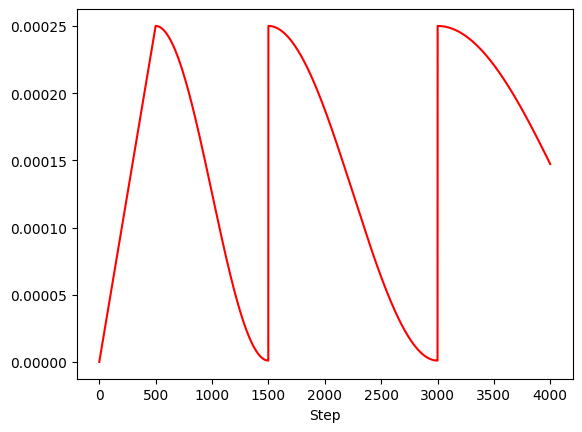

In [38]:
# compute lr
test_schedule = CosineRestartSchedule(warmup_steps=500, cycle_steps=1000)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

#6.model train

1. config 일단 고정하고 lr scheduler 차이를 비교.
2. prenorm, valid dataset 추가

In [22]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 32007,
 'i_pad': 0}

In [23]:
pre_train_model1 = build_model_pre_train(config)
pre_train_model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_tokens          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segments            │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert (BERT)         │ [(None, 256),     │ 10,629,632 │ enc_tokens[0][0], │
│                     │ (None, None,      │            │ segments[0][0]    │
│                     │ 32007)]           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_nsp          │ (None, 2)         │     66,304 │ bert[0][0]        │
│ (PooledOutput)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nsp (Softmax)       │ (None, 2)         │          0 │ pooled_nsp[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlm (Softmax)       │ (None, None,      │          0 │ bert[0][1]        │
│                     │ 32007)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,695,936 (40.80 MB)

 Trainable params: 10,695,936 (40.80 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 140
batch_size = BATCH_SIZE

# optimizer
n_cycles = 5
cycle_mult = 1.2
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
warmup_steps = max(500, int(train_steps * 0.05))  # 5% warmup
total_decay_steps = train_steps - warmup_steps

if cycle_mult == 1.0:
  init_cycle_steps = total_decay_steps // n_cycles
else:
  total_ratio = (cycle_mult ** n_cycles - 1) / (cycle_mult - 1)
  init_cycle_steps = int(total_decay_steps / total_ratio)

learning_rate = CosineRestartSchedule(warmup_steps=warmup_steps, cycle_steps=init_cycle_steps)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model1.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

In [25]:
save_weights = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/bert_pre_train.weights.h5",
    monitor="val_mlm_lm_acc",
    verbose=1,
    save_best_only=True,
    mode="max",
    save_freq="epoch",
    save_weights_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_mlm_lm_acc",
    patience=16,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

history = pre_train_model1.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=[save_weights, early_stopping]
)


Epoch 1/140
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 844ms/step - loss: 198.2409 - mlm_lm_acc: 0.0840 - mlm_loss: 197.5479 - nsp_acc: 0.5022 - nsp_loss: 0.6931
Epoch 1: val_mlm_lm_acc improved from -inf to 0.04327, saving model to /content/drive/MyDrive/bert_pre_train.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - loss: 198.2180 - mlm_lm_acc: 0.0840 - mlm_loss: 197.5249 - nsp_acc: 0.5022 - nsp_loss: 0.6931 - val_loss: 170.5801 - val_mlm_lm_acc: 0.0433 - val_mlm_loss: 169.8876 - val_nsp_acc: 0.4943 - val_nsp_loss: 0.6925
Epoch 2/140
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - loss: 168.9843 - mlm_lm_acc: 0.0459 - mlm_loss: 168.2918 - nsp_acc: 0.5121 - nsp_loss: 0.6925
Epoch 2: val_mlm_lm_acc improved from 0.04327 to 0.06697, saving model to /content/drive/MyDrive/bert_pre_train.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 534s 1s/step - loss: 168.9832 - mlm_lm_acc: 0.0459 - mlm_loss: 168.2906 - nsp_acc: 0.5121 - nsp_loss: 0.6925 - val_loss: 166.4963 - val_mlm_lm_acc: 0.0670 - val_mlm_loss: 1

KeyboardInterrupt: 

In [33]:
history = {
    'loss': [
        198.2180, 168.9832, 163.8261, 156.6691, 152.9046, 150.1896, 147.0574,
        142.4951, 132.1323, 123.6779, 118.7087, 114.7448, 112.1285, 110.0153,
        108.5286, 107.0559, 106.0036, 105.1400, 104.2376, 103.7886, 103.3252,
        102.8524, 102.7622, 102.6685, 102.4691, 104.6186, 103.7881, 102.5919,
        101.4509, 100.5653, 99.6415, 98.7518, 97.9530, 97.3037, 96.6591,
        95.8587, 95.2994, 94.7876, 94.4678, 94.1618, 93.4937, 93.2418,
        92.9227, 92.6874, 92.3077, 92.1208, 91.9589, 91.8170, 91.6394,
        91.6267, 91.4645, 91.5234, 94.5407, 94.2422, 93.9121, 93.3360,
        92.9315, 92.4452, 92.0099, 91.8359, 91.3683, 90.9284, 90.5767,
        90.2341, 89.8826, 89.5668, 89.1127, 88.8769, 88.6955, 88.3164,
        88.0532, 87.8501, 87.5764
    ],
    'mlm_lm_acc': [
        0.0840, 0.0459, 0.0799, 0.1246, 0.1346, 0.1369, 0.1412, 0.1492,
        0.1675, 0.1853, 0.1987, 0.2113, 0.2177, 0.2242, 0.2282, 0.2332,
        0.2367, 0.2394, 0.2423, 0.2435, 0.2452, 0.2470, 0.2470, 0.2478,
        0.2486, 0.2430, 0.2469, 0.2510, 0.2555, 0.2592, 0.2628, 0.2660,
        0.2687, 0.2711, 0.2735, 0.2763, 0.2791, 0.2810, 0.2819, 0.2826,
        0.2854, 0.2862, 0.2875, 0.2878, 0.2896, 0.2905, 0.2911, 0.2915,
        0.2925, 0.2928, 0.2934, 0.2930, 0.2820, 0.2834, 0.2841, 0.2865,
        0.2886, 0.2901, 0.2918, 0.2921, 0.2938, 0.2951, 0.2972,
        0.2982, 0.3002, 0.3006, 0.3027, 0.3037, 0.3041, 0.3058,
        0.3071, 0.3068, 0.3086
    ],
    'mlm_loss': [
        197.5249, 168.2906, 163.1443, 156.0087, 152.2535, 149.5430, 146.4168,
        141.8580, 131.4925, 123.0387, 118.0719, 114.1092, 111.4942, 109.3829,
        107.8965, 106.4258, 105.3751, 104.5124, 103.6108, 103.1624, 102.7004,
        102.2276, 102.1386, 102.0445, 101.8447, 103.9925, 103.1633, 101.9691,
        100.8299, 99.9453, 99.0219, 98.1343, 97.3357, 96.6874, 96.0433,
        95.2431, 94.6846, 94.1739, 93.8539, 93.5484, 92.8812, 92.6302,
        92.3115, 92.0771, 91.6980, 91.5109, 91.3493, 91.2071, 91.0295,
        91.0179, 90.8551, 90.9140, 93.9269, 93.6290, 93.2999, 92.7242,
        92.3205, 91.8341, 91.3995, 91.2257, 90.7580, 90.3193, 89.9684,
        89.6265, 89.2756, 88.9598, 88.5075, 88.2719, 88.0903, 87.7125,
        87.4507, 87.2483, 86.9748
    ],
    'nsp_acc': [
        0.5022, 0.5121, 0.5520, 0.5823, 0.5884, 0.5900, 0.5978, 0.5987,
        0.5961, 0.6006, 0.6015, 0.6012, 0.6035, 0.6087, 0.6083, 0.6097,
        0.6147, 0.6150, 0.6165, 0.6186, 0.6205, 0.6207, 0.6216, 0.6225,
        0.6207, 0.6160, 0.6169, 0.6180, 0.6206, 0.6237, 0.6202, 0.6234,
        0.6266, 0.6294, 0.6324, 0.6305, 0.6320, 0.6356, 0.6343, 0.6364,
        0.6392, 0.6404, 0.6407, 0.6441, 0.6454, 0.6474, 0.6470, 0.6461,
        0.6463, 0.6481, 0.6490, 0.6476, 0.6364, 0.6380, 0.6393, 0.6408,
        0.6425, 0.6432, 0.6416, 0.6431, 0.6451, 0.6466, 0.6496,
        0.6496, 0.6513, 0.6504, 0.6550, 0.6560, 0.6565, 0.6608,
        0.6633, 0.6634, 0.6633
    ],
    'nsp_loss': [
        0.6931, 0.6925, 0.6818, 0.6604, 0.6511, 0.6466, 0.6406, 0.6371,
        0.6398, 0.6392, 0.6368, 0.6356, 0.6342, 0.6325, 0.6321, 0.6301,
        0.6285, 0.6276, 0.6268, 0.6262, 0.6248, 0.6249, 0.6236, 0.6240,
        0.6244, 0.6261, 0.6248, 0.6228, 0.6209, 0.6199, 0.6196, 0.6175,
        0.6173, 0.6164, 0.6158, 0.6155, 0.6148, 0.6137, 0.6139, 0.6134,
        0.6125, 0.6117, 0.6113, 0.6103, 0.6097, 0.6099, 0.6095, 0.6099,
        0.6099, 0.6088, 0.6093, 0.6095, 0.6138, 0.6132, 0.6122, 0.6118,
        0.6111, 0.6112, 0.6105, 0.6101, 0.6103, 0.6091, 0.6082,
        0.6076, 0.6070, 0.6070, 0.6052, 0.6051, 0.6052, 0.6039,
        0.6025, 0.6018, 0.6016
    ],
    'val_loss': [
        170.5801, 166.4963, 158.5815, 154.8024, 152.3131, 149.2565, 145.7279,
        135.2148, 126.1315, 121.0022, 117.0489, 114.1657, 112.5819, 110.7122,
        109.3150, 108.3298, 107.3709, 106.7607, 106.3020, 105.5509, 105.3299,
        104.8896, 104.9363, 104.7367, 106.6753, 105.8732, 105.0783, 104.1524,
        103.3652, 102.3365, 101.8147, 100.8088, 100.1993, 99.7265, 99.0828,
        98.3616, 98.0213, 97.5511, 97.1492, 97.0541, 96.7791, 96.4817,
        96.2077, 95.9918, 95.5756, 95.7272, 95.3731, 95.2736, 95.2653,
        95.1869, 95.3561, 97.4791, 97.5125, 96.9774, 96.8309, 96.5391,
        96.1834, 95.8517, 95.5400, 95.2965, 94.7998, 94.4646, 94.4579,
        93.9630, 93.7390, 93.4851, 93.6985, 93.2397, 92.9204, 92.5327,
        92.5457, 92.5677, 92.5029
    ],
    'val_mlm_lm_acc': [
        0.04327, 0.06697, 0.12021, 0.12996, 0.13288, 0.13765, 0.14307,
        0.16193, 0.18042, 0.19496, 0.20655, 0.21648, 0.21949, 0.22610,
        0.23084, 0.23372, 0.23824, 0.23994, 0.24015, 0.24331, 0.24561,
        0.24683, 0.24620, 0.24719, 0.24120, 0.24550, 0.24908, 0.25289,
        0.25771, 0.25985, 0.26355, 0.26744, 0.27022, 0.27256, 0.27487,
        0.27682, 0.27951, 0.28073, 0.28266, 0.28321, 0.28343, 0.28489,
        0.28600, 0.28682, 0.28847, 0.28850, 0.28943, 0.28952, 0.28998,
        0.29034, 0.28910, 0.28180, 0.28300, 0.28370, 0.28450, 0.28520,
        0.28600, 0.28740, 0.28940, 0.28960, 0.29334, 0.29373, 0.29180,
        0.29568, 0.29579, 0.29757, 0.29650, 0.29767, 0.30055, 0.30189,
        0.30120, 0.30110, 0.30369
    ],
    'val_mlm_loss': [
        169.8876, 165.8055, 157.9470, 154.1793, 151.6921, 148.6448, 145.1232,
        134.6081, 125.5260, 120.3910, 116.4453, 113.5664, 111.9852, 110.1161,
        108.7195, 107.7372, 106.7792, 106.1699, 105.7129, 104.9622, 104.7433,
        104.3019, 104.3496, 104.1498, 106.0875, 105.2885, 104.4964, 103.5720,
        102.7868, 101.7590, 101.2398, 100.2341, 99.6266, 99.1538, 98.5099,
        97.7909, 97.4497, 96.9792, 96.5795, 96.4841, 96.2096, 95.9110,
        95.6377, 95.4225, 95.0062, 95.1579, 94.8037, 94.7046, 94.6962,
        94.6181, 94.7869, 96.9083, 96.9430, 96.4075, 96.2588, 95.9704,
        95.6154, 95.2819, 94.9686, 94.7277, 94.2291, 93.8961, 93.8900,
        93.3932, 93.1711, 92.9166, 93.1302, 92.6713, 92.3510, 91.9629,
        91.9769, 91.9992, 91.9333
    ],
    'val_nsp_acc': [
        0.4943, 0.5141, 0.6151, 0.6321, 0.6264, 0.6358, 0.6508, 0.6472,
        0.6439, 0.6443, 0.6482, 0.6581, 0.6603, 0.6590, 0.6598, 0.6632,
        0.6661, 0.6647, 0.6693, 0.6660, 0.6702, 0.6693, 0.6702, 0.6691,
        0.6662, 0.6708, 0.6712, 0.6729, 0.6771, 0.6756, 0.6792, 0.6816,
        0.6809, 0.6805, 0.6835, 0.6845, 0.6831, 0.6834, 0.6880, 0.6879,
        0.6860, 0.6849, 0.6851, 0.6873, 0.6872, 0.6862, 0.6863, 0.6877,
        0.6876, 0.6872, 0.6859, 0.6836, 0.6872, 0.6872, 0.6840, 0.6850,
        0.6901, 0.6856, 0.6836, 0.6875, 0.6892, 0.6894, 0.6894,
        0.6878, 0.6897, 0.6905, 0.6867, 0.6890, 0.6878, 0.6890,
        0.6881, 0.6877, 0.6896
    ],
    'val_nsp_loss': [
        0.6925, 0.6908, 0.6345, 0.6231, 0.6211, 0.6117, 0.6046, 0.6067,
        0.6056, 0.6112, 0.6037, 0.5992, 0.5967, 0.5961, 0.5956, 0.5926,
        0.5917, 0.5908, 0.5891, 0.5887, 0.5866, 0.5877, 0.5867, 0.5869,
        0.5878, 0.5847, 0.5819, 0.5804, 0.5784, 0.5774, 0.5749, 0.5747,
        0.5727, 0.5728, 0.5729, 0.5708, 0.5716, 0.5719, 0.5698, 0.5700,
        0.5694, 0.5707, 0.5700, 0.5693, 0.5694, 0.5693, 0.5695, 0.5690,
        0.5691, 0.5688, 0.5691, 0.5707, 0.5695, 0.5699, 0.5722, 0.5687,
        0.5679, 0.5698, 0.5714, 0.5688, 0.5706, 0.5685, 0.5679,
        0.5699, 0.5680, 0.5685, 0.5683, 0.5685, 0.5694, 0.5699,
        0.5687, 0.5685, 0.5696
    ]
}

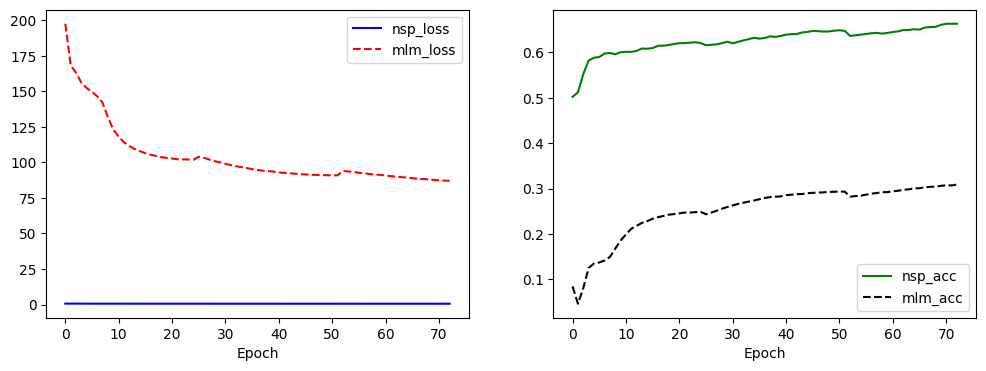

In [34]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

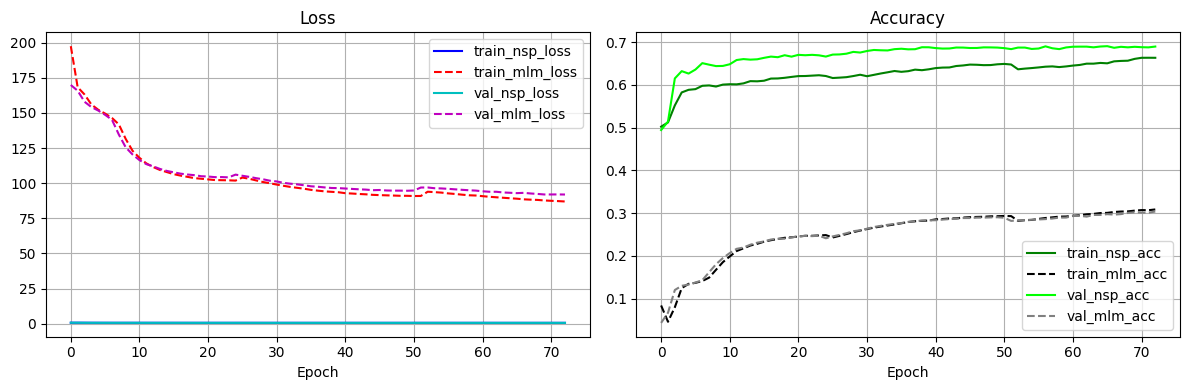

In [35]:
plt.figure(figsize=(12, 4))

# ── Loss Plot ──
plt.subplot(1, 2, 1)
plt.plot(history['nsp_loss'], 'b-', label='train_nsp_loss')
plt.plot(history['mlm_loss'], 'r--', label='train_mlm_loss')

if 'val_nsp_loss' in history:
    plt.plot(history['val_nsp_loss'], 'c-', label='val_nsp_loss')
if 'val_mlm_loss' in history:
    plt.plot(history['val_mlm_loss'], 'm--', label='val_mlm_loss')

plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()
plt.grid(True)

# ── Accuracy Plot ──
plt.subplot(1, 2, 2)
plt.plot(history['nsp_acc'], 'g-', label='train_nsp_acc')
plt.plot(history['mlm_lm_acc'], 'k--', label='train_mlm_acc')

if 'val_nsp_acc' in history:
    plt.plot(history['val_nsp_acc'], 'lime', linestyle='-', label='val_nsp_acc')
if 'val_mlm_lm_acc' in history:
    plt.plot(history['val_mlm_lm_acc'], 'gray', linestyle='--', label='val_mlm_acc')

plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

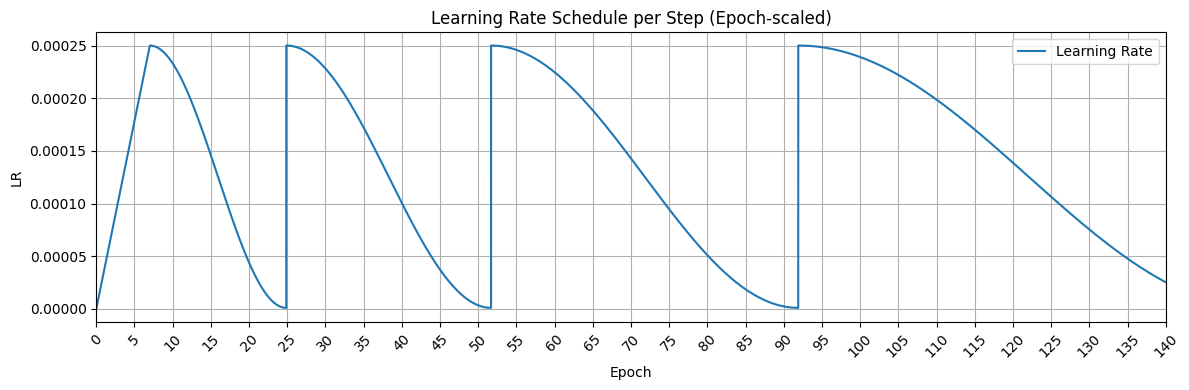

In [32]:
steps_per_epoch = 500
total_epochs = 140
total_steps = steps_per_epoch * total_epochs

n_cycles = 5
cycle_mult = 1.2
train_steps = total_steps
warmup_steps = max(500, int(train_steps * 0.05))  # 5% warmup
total_decay_steps = train_steps - warmup_steps

if cycle_mult == 1.0:
  init_cycle_steps = total_decay_steps // n_cycles
else:
  total_ratio = (cycle_mult ** n_cycles - 1) / (cycle_mult - 1)
  init_cycle_steps = int(total_decay_steps / total_ratio)

learning_rate = CosineRestartSchedule(warmup_steps=warmup_steps, cycle_steps=init_cycle_steps)

# step 단위로 LR 추적
lrs = [learning_rate(step).numpy() for step in range(total_steps)]

xtick_pos = np.arange(0, len(lrs)+1, steps_per_epoch)
xtick_labels = [str(x // steps_per_epoch) for x in xtick_pos]

plt.figure(figsize=(12, 4))
plt.xlim(0, len(lrs))
plt.plot(lrs, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning Rate Schedule per Step (Epoch-scaled)")
plt.grid(True)
plt.legend()

show_every = 5
filtered_ticks = xtick_pos[::show_every]
filtered_labels = xtick_labels[::show_every]

plt.xticks(filtered_ticks, filtered_labels, rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
history = pre_train_model1.fit(
    x=pre_train_inputs,
    y=pre_train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(pre_valid_inputs, pre_valid_labels),
    callbacks=[save_weights, early_stopping]
)

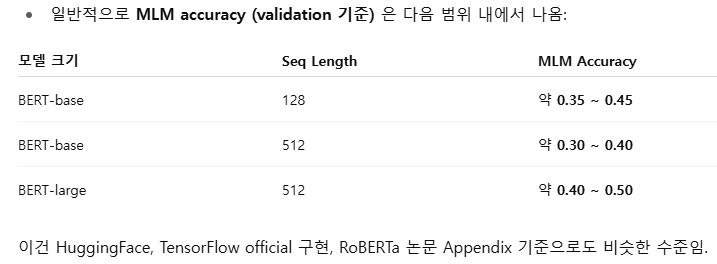

dynamic mask라서 그런지 mlm은 train, valid 차이가 크지 않음, 반면 nsp는 train, valid 차이가 큼

dataset도 shuffle이라 매 epoch마다 섞임

dynamic 고려했을 때 n_layer나 capacity를 더 늘려도 좋을거같음

대략 25,51에서 올랐다가 다시 내려가는 움직임관찰, 정확히 cosinerestart 지점과 동일함.

첫 restart는 local minima or flat minima를 벗어난다고 보여지나 두번 째는 학습을 더 해봐야 알것같음 accuracy가 0.29에서 0.30대로 내려가는 건 보이지만 restart없어도 가능했을지는 확실하지 않음
